In [1]:
import lightgbm as lgb, catboost as cat

In [2]:
import pandas as pd
import joblib

In [3]:
import numpy as np
import random

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [6]:
#pd.read_csv("data_phase_one/coords.csv", header=None)

In [7]:
data = read_merge_data()

Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23'

In [8]:
def get_more_features(target):
    monthly_avg = []
    monthly_std = []
    for i in range(12):
        current_month = []
        j = 0
        while 5774*12*(j+i)+5774 <= len(target):
            current_month.append(target.iloc[5774*12*(j+i):5774*12*(j+i)+5774].values)
            #print(current_month[-1].shape)
            j += 1
        monthly_avg.append(np.stack(current_month, axis=0).mean(0))
        monthly_std.append(np.stack(current_month, axis=0).std(0))
    return np.concatenate([np.stack(monthly_avg, axis=1), np.stack(monthly_std, axis=1)], axis=1)

In [9]:
#monthly_stats = get_more_features(data["target"])

In [10]:
#np.save("monthly_stats.npy", monthly_stats)

In [11]:
monthly_stats = np.load("monthly_stats.npy")

In [12]:
monthly_stats = np.tile(monthly_stats,(len(data)//5774,1))

In [13]:
monthly_stats_df = pd.DataFrame(monthly_stats, columns=[f"add_feat_{i}" for i in range(24)])

In [14]:
data = pd.concat([data.reset_index(drop=True), monthly_stats_df], axis=1)

In [15]:
data

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,add_feat_14,add_feat_15,add_feat_16,add_feat_17,add_feat_18,add_feat_19,add_feat_20,add_feat_21,add_feat_22,add_feat_23
0,-64.0,-180.0000,98848.380,99195.690,99320.914,98469.160,98149.220,98269.195,98373.570,97659.090,...,0.590394,0.578681,0.576274,0.548224,0.544279,0.540694,0.538946,0.543125,0.545212,0.543470
1,-64.0,-177.1875,98898.160,99224.910,99322.336,98480.360,98138.870,98256.570,98282.520,97621.800,...,0.600649,0.590663,0.582925,0.571722,0.569716,0.560472,0.563940,0.566644,0.561656,0.562393
2,-64.0,-174.3750,98945.240,99245.610,99325.310,98495.400,98137.020,98236.720,98203.670,97581.520,...,0.635043,0.606403,0.587164,0.555811,0.557459,0.557803,0.561152,0.562297,0.552638,0.549103
3,-64.0,-171.5625,98972.610,99259.370,99331.414,98527.730,98152.336,98207.220,98140.990,97533.445,...,0.600441,0.585508,0.584608,0.552524,0.554519,0.554806,0.555235,0.559270,0.558470,0.546810
4,-64.0,-168.7500,98969.490,99280.640,99335.805,98585.020,98189.350,98166.090,98090.790,97491.330,...,0.594315,0.586059,0.590216,0.585997,0.589768,0.594207,0.576754,0.578006,0.574201,0.550796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4832833,62.0,-5.6250,100949.125,101105.414,99110.170,100612.875,101548.020,100916.230,101062.870,101320.266,...,0.346133,0.347553,0.343245,0.345732,0.347781,0.350528,0.353242,0.354397,0.357285,0.359468
4832834,62.0,-2.8125,101014.790,101204.120,99232.990,100601.810,101610.990,100828.586,101021.590,101323.670,...,0.411259,0.412691,0.409359,0.412484,0.412936,0.411689,0.414810,0.418158,0.421191,0.412557
4832835,62.0,0.0000,101065.984,101295.586,99371.120,100607.914,101676.370,100745.620,100973.234,101342.250,...,0.436968,0.423618,0.420498,0.409317,0.411599,0.408346,0.408299,0.408404,0.408727,0.403374
4832836,62.0,2.8125,101128.520,101377.560,99537.330,100660.810,101771.670,100720.375,100953.950,101417.695,...,0.595102,0.583280,0.582017,0.577438,0.579690,0.573577,0.575215,0.565446,0.560426,0.558835


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [17]:
cv = KFold(n_splits=5, shuffle=True)

In [18]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 8,
    'num_leaves': 255,
    "learning_rate": 0.01,
    "n_estimators": 2000,
    #"colsample_bytree": 0.8, 
    #"colsample_bynode": 0.8,
    "verbose": -1,
    "device": "gpu",
    "gpu_device_id": 1}

In [19]:
params_catb = dict(
task_type="GPU",
devices='1',
reg_lambda=0.438, learning_rate=0.1,
max_depth=8, min_data_in_leaf=50,
n_estimators=2000, verbose=50,
objective='RMSE')

In [20]:
params_catb

{'task_type': 'GPU',
 'devices': '1',
 'reg_lambda': 0.438,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_data_in_leaf': 50,
 'n_estimators': 2000,
 'verbose': 50,
 'objective': 'RMSE'}

In [21]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    lgb_model = lgb.LGBMRegressor(**params_lgb, random_state=state)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)])
    joblib.dump(lgb_model, f"./trained3/lgb_model_fold{state}.joblib")


Train: 3866270, Val: 966568


Train: 3866270, Val: 966568


Train: 3866270, Val: 966568


Train: 3866271, Val: 966567


Train: 3866271, Val: 966567



In [22]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    catb_model = cat.CatBoostRegressor(**params_catb, random_state=state)
    catb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=200)
    joblib.dump(catb_model, f"./trained3/catb_model_fold{state}.joblib")


Train: 3866270, Val: 966568

0:	learn: 0.6049746	test: 0.6062935	best: 0.6062935 (0)	total: 26.2ms	remaining: 52.3s
50:	learn: 0.5296514	test: 0.5318658	best: 0.5318658 (50)	total: 1.15s	remaining: 43.9s
100:	learn: 0.5250806	test: 0.5277828	best: 0.5277828 (100)	total: 2.29s	remaining: 43.1s
150:	learn: 0.5221449	test: 0.5252145	best: 0.5252145 (150)	total: 3.45s	remaining: 42.3s
200:	learn: 0.5199432	test: 0.5233868	best: 0.5233868 (200)	total: 4.62s	remaining: 41.4s
250:	learn: 0.5179033	test: 0.5217066	best: 0.5217066 (250)	total: 5.78s	remaining: 40.3s
300:	learn: 0.5162292	test: 0.5204130	best: 0.5204130 (300)	total: 6.92s	remaining: 39s
350:	learn: 0.5145869	test: 0.5191346	best: 0.5191346 (350)	total: 8.07s	remaining: 37.9s
400:	learn: 0.5130627	test: 0.5179723	best: 0.5179723 (400)	total: 9.24s	remaining: 36.9s
450:	learn: 0.5116078	test: 0.5168799	best: 0.5168799 (450)	total: 10.4s	remaining: 35.7s
500:	learn: 0.5103458	test: 0.5159909	best: 0.5159909 (500)	total: 11.5s	rema

In [23]:
pred_lgb = lgb_model.predict(X_val[:200])
pred_catb = catb_model.predict(X_val[:200])

In [24]:
print("lgbm error:", np.linalg.norm(y_val[:200]-pred_lgb))
print("catboost error:", np.linalg.norm(y_val[:200]-pred_catb))

lgbm error: 4.332867160836001
catboost error: 4.420891460149753


In [25]:
import matplotlib.pyplot as plt

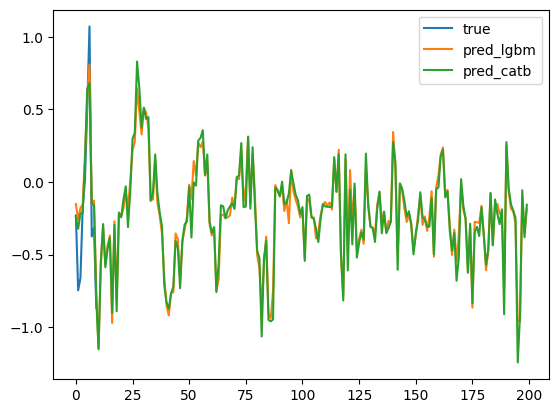

In [26]:
plt.plot(y_val[:10])
plt.plot(pred_lgb)
plt.plot(pred_catb)
plt.legend(["true", "pred_lgbm", "pred_catb"])
plt.show()